## Glow normalizing flows

This notebook provides a simple example of training Glow on MNIST.

Note that, for the default architecture settings, you *will* need a GPU in order to run this code.

As can be seen below, 10 epochs took roughly 1.2 hours on a Google Cloud NVIDIA V100 GPU.

For MNIST, one could also probably get away with a smaller model. This can be adjusted via the `num_layers` and `depth` arguments, as well as the `coupling_nn_ctor` argument, which builds the deep neural network used in the coupling layers.

In [1]:
import sys
sys.path += ['..']

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from normalizing_flows.flows import Invert
from normalizing_flows.flows.glow import GlowFlow
from normalizing_flows.models import FlowLVM
from normalizing_flows.models.optimization import LinearWarmu
#tf.config.experimental_run_functions_eagerly(True)

In [3]:
(X_train,_),_ = mnist.load_data()
batch_size = 10
X_train = np.expand_dims(X_train, axis=-1)
# resizing to 32x32 makes things a bit easier vis-a-vis the squeeze op
resize = lambda x: tf.image.resize(x, (32,32), method='bilinear')
X_train_ds = tf.data.Dataset.from_tensor_slices(X_train.astype(np.float32))
X_train_ds = X_train_ds.map(lambda x: x / 255. - 0.5) \
                       .map(resize) \
                       .shuffle(buffer_size=X_train.shape[0]) \
                       .batch(batch_size)

In [4]:
glow = Invert(GlowFlow(num_layers=3, depth=8))
learning_rate = LinearWarmupSchedule(1.0E-4, num_warmup_steps=100)
model = FlowLVM(glow, input_shape=(None,32,32,1), num_bins=256,
                optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate))

In [5]:
model.train(X_train_ds, X_train.shape[0] // batch_size, num_epochs=10)

100%|██████████| 60000/60000 [1:14:17<00:00, 13.46it/s, loss=4.13, nll=4.09]  


In [15]:
samples = model.sample(n=6)

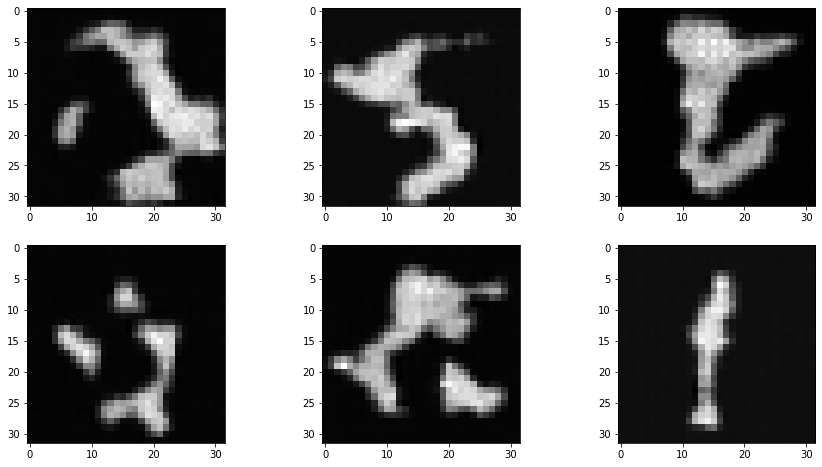

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3*5,2*4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(np.squeeze(255*(samples[i]+0.5)), cmap='gray')
plt.show()